In [2]:
!pip install timm
import numpy as np
import os
from PIL import Image
import json
import timm
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

# Prepare data

Dataset: [FreiHAND Dataset](https://lmb.informatik.uni-freiburg.de/resources/datasets/FreihandDataset.en.html)

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# В корневую папку Гугл диска необходимо положить архив Hands/FreiHAND.zip
!unzip -o drive/MyDrive/Hands/FreiHAND.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: training/rgb/00078090.jpg  
  inflating: training/rgb/00086511.jpg  
  inflating: training/rgb/00062574.jpg  
  inflating: training/rgb/00024675.jpg  
  inflating: training/rgb/00064220.jpg  
  inflating: training/rgb/00084285.jpg  
  inflating: training/rgb/00029517.jpg  
  inflating: training/rgb/00034885.jpg  
  inflating: training/rgb/00112649.jpg  
  inflating: training/rgb/00071984.jpg  
  inflating: training/rgb/00026232.jpg  
  inflating: training/rgb/00051979.jpg  
  inflating: training/rgb/00118532.jpg  
  inflating: training/rgb/00017754.jpg  
  inflating: training/rgb/00080877.jpg  
  inflating: training/rgb/00069959.jpg  
  inflating: training/rgb/00060878.jpg  
  inflating: training/rgb/00065363.jpg  
  inflating: training/rgb/00088965.jpg  
  inflating: training/rgb/00059316.jpg  
  inflating: training/rgb/00053337.jpg  
  inflating: training/rgb/00016264.jpg  
  inflating: training/rgb/0012

In [6]:
class FreiHAND(Dataset):
    """Class to load FreiHAND dataset."""

    def __init__(self, set_type="train"):
        self.train_part = 0.75
        self.val_part = 0.15
        self.test_part = 0.1
        self.image_dir = 'training/rgb'
        self.image_names = np.sort(os.listdir(self.image_dir))

        fn_K_matrix = 'training_K.json'
        with open(fn_K_matrix, "r") as f:
            self.K_matrix = np.array(json.load(f))

        fn_anno = 'training_xyz.json'
        with open(fn_anno, "r") as f:
            self.anno = np.array(json.load(f))

        if set_type == 'train':
            st = 0
            end = int(self.train_part * len(self.anno))
        elif set_type == 'val':
            st = int(self.train_part * len(self.anno)) + 1
            end = int((self.train_part + self.val_part) * len(self.anno))
        else:
            st = int((self.train_part + self.val_part) * len(self.anno)) + 1
            end = len(self.anno)

        self.image_names = self.image_names[st:end]
        self.K_matrix = self.K_matrix[st:end]
        self.anno = self.anno[st:end]

        self.image_raw_transform = transforms.ToTensor()
        self.image_transform = transforms.Compose(
            [
                transforms.Resize(128),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.3950, 0.4323, 0.2954],
                    std=[0.1966, 0.1734, 0.1836],
                ),
            ]
        )

    def __len__(self):
        return len(self.anno)

    def projectPoints(self, xyz, K):
        """
        Projects 3D coordinates into image space.
        Function taken from https://github.com/lmb-freiburg/freihand
        """
        xyz = np.array(xyz)
        K = np.array(K)
        uv = np.matmul(K, xyz.T).T
        return uv[:, :2] / uv[:, -1:]

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_raw = Image.open(os.path.join(self.image_dir, image_name))
        image = self.image_transform(image_raw)
        image = np.asarray(image)
        
        keypoints = self.projectPoints(self.anno[idx], self.K_matrix[idx])
        keypoints = keypoints / 224
        keypoints = torch.from_numpy(keypoints)

        return image, torch.Tensor(keypoints)

In [7]:
train_dataset = FreiHAND(set_type="train")
train_dataloader = DataLoader(
    train_dataset, batch_size=48, shuffle=True,  drop_last=True, num_workers=2,
    )

val_dataset = FreiHAND(set_type="val")
val_dataloader = DataLoader(
    val_dataset, batch_size=48, shuffle=False,  drop_last=True, num_workers=2,
    )

In [8]:
import matplotlib.pyplot as plt

COLORMAP = {
    "thumb": {"ids": [0, 1, 2, 3, 4], "color": "g"},
    "index": {"ids": [0, 5, 6, 7, 8], "color": "c"},
    "middle": {"ids": [0, 9, 10, 11, 12], "color": "b"},
    "ring": {"ids": [0, 13, 14, 15, 16], "color": "m"},
    "little": {"ids": [0, 17, 18, 19, 20], "color": "r"},
}

def show_data(dataset, n_samples=12):
    """
    Function to visualize data
    Input: torch.utils.data.Dataset
    """
    n_cols = 4
    n_rows = int(np.ceil(n_samples / n_cols))
    plt.figure(figsize=[15, n_rows * 4])

    ids = np.random.choice(dataset.__len__(), n_samples, replace=False)
    for i, id_ in enumerate(ids, 1):
        image, keypoints = dataset.__getitem__(id_)

        image = np.moveaxis(image, 0, -1)
        keypoints = keypoints.numpy()
        keypoints = keypoints * 128
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
    plt.tight_layout()
    plt.show()


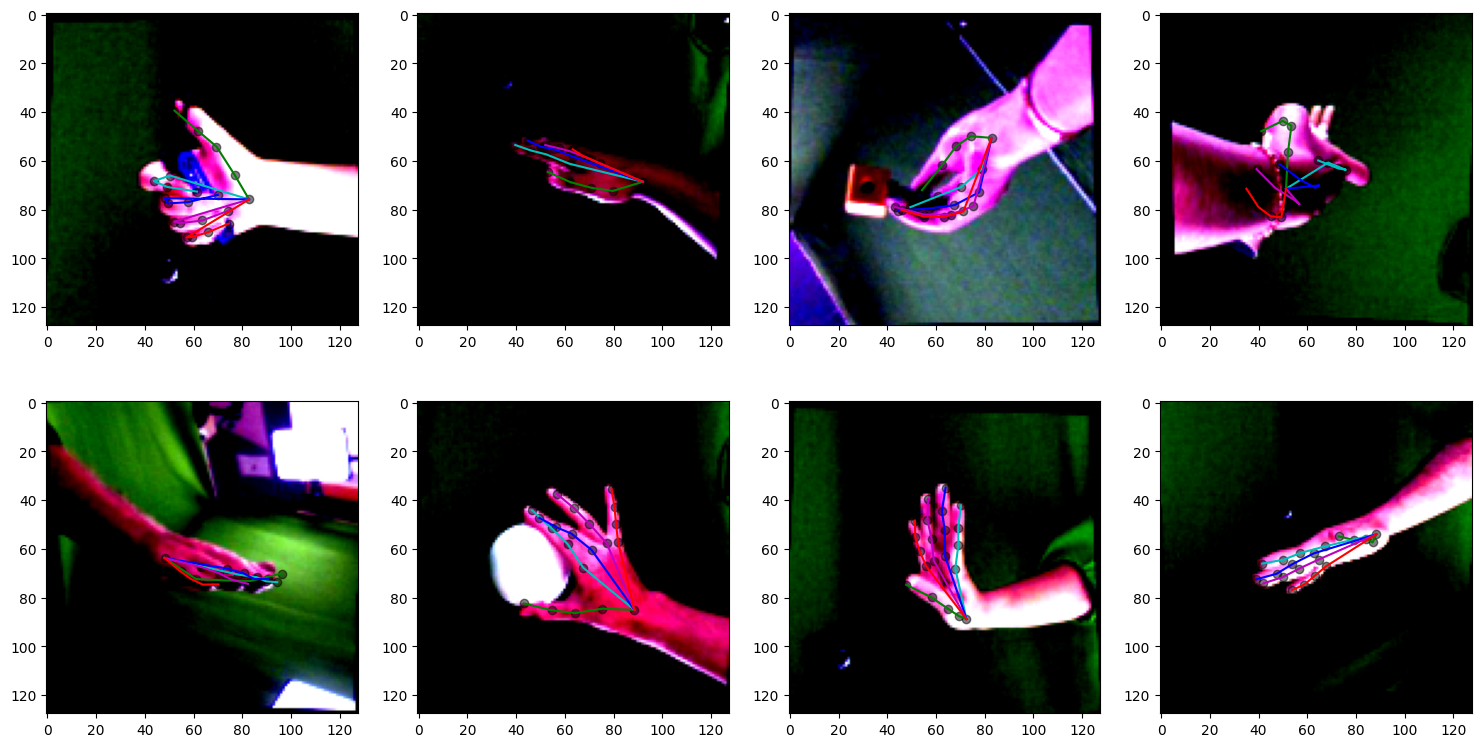

In [ ]:
# visualize random batch of data train samples + labels
show_data(train_dataset, n_samples=8)

# Metrics

## Object Keypoint Similarity

In [9]:
def oks(y_true, y_pred, visibility):
    # You might want to set these global constant
    # outside the function scope
    KAPPA = np.array([1] * len(y_true))
    # The object scale
    # You might need a dynamic value for the object scale
    SCALE = 1.0

    # Compute the L2/Euclidean Distance
    distances = np.linalg.norm(y_pred - y_true, axis=-1)
    # Compute the exponential part of the equation
    exp_vector = np.exp(-(distances**2) / (2 * (SCALE**2) * (KAPPA**2)))
    # The numerator expression
    numerator = np.dot(exp_vector, visibility.astype(bool).astype(int))
    # The denominator expression
    denominator = np.sum(visibility.astype(bool).astype(int))
    return numerator / denominator

# Create model

In [ ]:
model = timm.create_model('mobilenetv2_050', pretrained=True, num_classes=0)
model.global_pool = nn.Flatten()
model.classifier = nn.Sequential(
    nn.Linear(20480, 42),
    nn.Sigmoid()
)
model.to(device);

In [ ]:
EPOCHS = 100
lr = 0.001

optimizer = optim.AdamW(model.parameters(), lr)

criterion = nn.MSELoss()

In [ ]:
for epoch in range(EPOCHS):
    
    model.train()
        
    train_loss = []
    train_predictions = []
    train_targets = []
    for batch, targets in tqdm(train_dataloader, desc=f"Epoch: {epoch}"):
        optimizer.zero_grad()
        
        batch = batch.to(device)
        targets = targets.to(device)
        
        predictions = model(batch)
        targets = targets.reshape(predictions.shape)

        loss = criterion(predictions.float(), targets.float()) 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
        predictions = predictions.cpu().detach().numpy().reshape(-1, 3)
        train_predictions.extend(predictions)
        targets = targets.cpu().detach().numpy().reshape(-1, 3)
        train_targets.extend(targets)
    
    train_targets = np.array(train_targets)
    train_predictions = np.array(train_predictions)
    print('Training loss:', np.mean(train_loss))
    print('Train OKS:', oks(train_targets[:, :2], train_predictions[:, :2], train_targets[:, 2]))
    
    model.eval()
        
    val_predictions = []
    val_targets = []
    for batch, targets in tqdm(val_dataloader, desc=f"Epoch: {epoch}"):
        
        with torch.no_grad():
        
            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)
            
            predictions = predictions.cpu().numpy().reshape(-1, 3)
            val_predictions.extend(predictions)
            targets = targets.cpu().numpy().reshape(-1, 3)
            val_targets.extend(targets)
        
    val_targets = np.array(val_targets)
    val_predictions = np.array(val_predictions)
    print('Val OKS:', oks(val_targets[:, :2], val_predictions[:, :2], val_targets[:, 2]))

    if epoch % 25 == 0:
        torch.save(model.state_dict(), f'/content/drive/MyDrive/model_{epoch}.pt')

Epoch: 0:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.2560855984159811
Train OKS: 0.7760072139708867


Epoch: 0:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.7765917151971258


Epoch: 1:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.2560866734408957
Train OKS: 0.7760057806772607


Epoch: 1:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.7765917151971258


Epoch: 2:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.25608326570959544
Train OKS: 0.7760093439123438


Epoch: 2:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.7765917151971258


Epoch: 3:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.25607377581122354
Train OKS: 0.7760155003680367


Epoch: 3:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.7765917151971258


Epoch: 4:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.2560816420110192
Train OKS: 0.776009402275562


Epoch: 4:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.7765917151971258


Epoch: 5:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.25608744407732653
Train OKS: 0.7760059928515568


Epoch: 5:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.7765917151971258


Epoch: 6:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.25608962703877547
Train OKS: 0.776006418659327


Epoch: 6:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.7765917153918385


Epoch: 7:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.25608894252401637
Train OKS: 0.776005914532089


Epoch: 7:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.7765917175668026


Epoch: 8:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.14403092827030098
Train OKS: 0.8735898983867675


Epoch: 8:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9961425613274242


Epoch: 9:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0035474543128800615
Train OKS: 0.9965549564483627


Epoch: 9:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9970239759157464


Epoch: 10:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.002996777926569834
Train OKS: 0.9970931137797491


Epoch: 10:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9973434351838457


Epoch: 11:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0026759478993673524
Train OKS: 0.9974047828587381


Epoch: 11:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9974521130933552


Epoch: 12:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0025006719951070552
Train OKS: 0.9975760228203628


Epoch: 12:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9974622874177529


Epoch: 13:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.002322479328791442
Train OKS: 0.9977511096872408


Epoch: 13:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9977820565992728


Epoch: 14:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0021793672670133587
Train OKS: 0.997889834003487


Epoch: 14:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.997898563125898


Epoch: 15:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.00205571524313959
Train OKS: 0.9980104177654014


Epoch: 15:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9979892035500176


Epoch: 16:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0019434622927077525
Train OKS: 0.9981187083883305


Epoch: 16:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9980741501809779


Epoch: 17:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0018561485371970403
Train OKS: 0.9982026467439439


Epoch: 17:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9981341088999381


Epoch: 18:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001771064277181006
Train OKS: 0.9982846922273758


Epoch: 18:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9982245763413266


Epoch: 19:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001668732043394203
Train OKS: 0.9983843444824284


Epoch: 19:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9982666225736703


Epoch: 20:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0015824842544026878
Train OKS: 0.9984663671944817


Epoch: 20:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983327928866781


Epoch: 21:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0015059940703259047
Train OKS: 0.9985408440233898


Epoch: 21:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983645356186094


Epoch: 22:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001429422065871401
Train OKS: 0.9986156363507365


Epoch: 22:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983865668258587


Epoch: 23:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0013994113393182917
Train OKS: 0.9986452999467071


Epoch: 23:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983641353293214


Epoch: 24:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0013812906501812889
Train OKS: 0.9986617594539146


Epoch: 24:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983677018669336


Epoch: 25:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0014054114841186903
Train OKS: 0.9986394232353889


Epoch: 25:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9982818348529133


Epoch: 26:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001507821559308346
Train OKS: 0.9985400847544987


Epoch: 26:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9980605412201015


Epoch: 27:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0015511147297027808
Train OKS: 0.9984982002248478


Epoch: 27:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9978762020830318


Epoch: 28:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001672420173601108
Train OKS: 0.9983799477324213


Epoch: 28:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9980069449216862


Epoch: 29:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0017562216488318152
Train OKS: 0.998298282716478


Epoch: 29:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9977552761066607


Epoch: 30:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0017153577481242499
Train OKS: 0.9983397891164318


Epoch: 30:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9979931540949956


Epoch: 31:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0017930310284608873
Train OKS: 0.9982647981195154


Epoch: 31:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9978568087842058


Epoch: 32:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001739428041541333
Train OKS: 0.99831643416333


Epoch: 32:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9979034056413579


Epoch: 33:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0017679508775014312
Train OKS: 0.9982871469230467


Epoch: 33:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9981409247576262


Epoch: 34:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0017255881347961167
Train OKS: 0.9983269447195842


Epoch: 34:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9981582898332617


Epoch: 35:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001693463220176705
Train OKS: 0.9983596910014204


Epoch: 35:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9977121853829961


Epoch: 36:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0016130443704112866
Train OKS: 0.9984389058224743


Epoch: 36:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9982112349803326


Epoch: 37:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0015987598886768384
Train OKS: 0.998452882171658


Epoch: 37:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9976223437483048


Epoch: 38:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001614515763142799
Train OKS: 0.9984364704031607


Epoch: 38:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.997809358448206


Epoch: 39:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0015977944078301555
Train OKS: 0.9984516327931054


Epoch: 39:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9982971606117981


Epoch: 40:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0015707046295860855
Train OKS: 0.998478493018736


Epoch: 40:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.998113643768575


Epoch: 41:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0014851168962195516
Train OKS: 0.9985611059322035


Epoch: 41:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983294756359867


Epoch: 42:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001546856312000552
Train OKS: 0.998500416129134


Epoch: 42:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9982002422256082


Epoch: 43:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0014509661846169029
Train OKS: 0.9985935975160681


Epoch: 43:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9984048158360328


Epoch: 44:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001378226290685198
Train OKS: 0.9986624923508369


Epoch: 44:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983545863981066


Epoch: 45:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0014761020942759796
Train OKS: 0.9985696918014225


Epoch: 45:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9980256369988695


Epoch: 46:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0014108564042601749
Train OKS: 0.9986315260278792


Epoch: 46:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9984044126204678


Epoch: 47:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001387887854448989
Train OKS: 0.9986541295668754


Epoch: 47:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9984789299970203


Epoch: 48:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0014184463459138545
Train OKS: 0.9986233906802748


Epoch: 48:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.99827769281375


Epoch: 49:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0013511604719976785
Train OKS: 0.9986886286809695


Epoch: 49:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985539710958191


Epoch: 50:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012802894533828165
Train OKS: 0.9987577027764808


Epoch: 50:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983975982672654


Epoch: 51:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0013812646541586807
Train OKS: 0.9986618509379804


Epoch: 51:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983175038976414


Epoch: 52:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001262020684185614
Train OKS: 0.9987748235042392


Epoch: 52:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9979466277188844


Epoch: 53:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012999892698401056
Train OKS: 0.9987370069907193


Epoch: 53:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983856932901762


Epoch: 54:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012983780438593758
Train OKS: 0.9987416539362192


Epoch: 54:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9982054845974196


Epoch: 55:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0013682880080451705
Train OKS: 0.9986730701132577


Epoch: 55:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985067235060887


Epoch: 56:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001238871746770781
Train OKS: 0.9987972473172497


Epoch: 56:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983559805972959


Epoch: 57:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001231775448247827
Train OKS: 0.9988037595457488


Epoch: 57:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9984882388718619


Epoch: 58:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0013303784996144634
Train OKS: 0.9987080384888244


Epoch: 58:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9986584947755276


Epoch: 59:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012135206102751063
Train OKS: 0.998822136095691


Epoch: 59:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9984649083926861


Epoch: 60:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012638841724292719
Train OKS: 0.9987738157266346


Epoch: 60:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9986468673644332


Epoch: 61:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012549409030031002
Train OKS: 0.9987814724806938


Epoch: 61:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9986230374196648


Epoch: 62:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012133152279810335
Train OKS: 0.9988223744729935


Epoch: 62:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9984418362776544


Epoch: 63:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012089619143750504
Train OKS: 0.9988262334859873


Epoch: 63:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985730192527777


Epoch: 64:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001236351784964928
Train OKS: 0.9987983854107625


Epoch: 64:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9984694037533836


Epoch: 65:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012054824156642664
Train OKS: 0.9988306825939486


Epoch: 65:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983872169523225


Epoch: 66:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012522308550285558
Train OKS: 0.9987847511391632


Epoch: 66:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9984188479337778


Epoch: 67:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012253466482534565
Train OKS: 0.9988104055916764


Epoch: 67:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9986466692738294


Epoch: 68:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001162773401771606
Train OKS: 0.998871452573076


Epoch: 68:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.998632048205598


Epoch: 69:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0011906721978677496
Train OKS: 0.9988436352732453


Epoch: 69:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9986073867345955


Epoch: 70:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0011994876836034227
Train OKS: 0.9988341900685533


Epoch: 70:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9984929799355559


Epoch: 71:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012031327053083208
Train OKS: 0.9988309696105341


Epoch: 71:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983890240432426


Epoch: 72:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001223325537674415
Train OKS: 0.9988106166972692


Epoch: 72:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9981031372795783


Epoch: 73:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012386102371667622
Train OKS: 0.9987978830011335


Epoch: 73:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985490633798446


Epoch: 74:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001121085909411575
Train OKS: 0.9989106216436778


Epoch: 74:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985202361789343


Epoch: 75:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001195509684974269
Train OKS: 0.9988392111770324


Epoch: 75:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9982972633405497


Epoch: 76:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0011723395110443454
Train OKS: 0.9988620397076095


Epoch: 76:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9987069581653687


Epoch: 77:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001220965763465978
Train OKS: 0.9988143882669517


Epoch: 77:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985668731678798


Epoch: 78:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0011168109200570336
Train OKS: 0.9989165185180086


Epoch: 78:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983411383197706


Epoch: 79:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0011432987291092698
Train OKS: 0.9988874608613261


Epoch: 79:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983055140536476


Epoch: 80:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012069597908370858
Train OKS: 0.998826815612459


Epoch: 80:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9986261842963959


Epoch: 81:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0011154079738056552
Train OKS: 0.9989159718472541


Epoch: 81:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983973650042571


Epoch: 82:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012600104614182955
Train OKS: 0.998775356519326


Epoch: 82:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985872701587336


Epoch: 83:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0011137714593462264
Train OKS: 0.9989174257232702


Epoch: 83:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9980787530930677


Epoch: 84:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001132496355805458
Train OKS: 0.9988992681787543


Epoch: 84:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985686447774919


Epoch: 85:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012142438581075857
Train OKS: 0.9988207277778496


Epoch: 85:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9982832272718318


Epoch: 86:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012199327280455247
Train OKS: 0.9988158915725635


Epoch: 86:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9984030457787165


Epoch: 87:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001096497826653122
Train OKS: 0.9989334703215659


Epoch: 87:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9986739641116564


Epoch: 88:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001063919161546308
Train OKS: 0.9989659048719081


Epoch: 88:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985771037797098


Epoch: 89:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012725029922389301
Train OKS: 0.9987643589057486


Epoch: 89:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.998474317568535


Epoch: 90:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0011388470502854435
Train OKS: 0.9988942898088734


Epoch: 90:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983680530714347


Epoch: 91:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0012061125148540568
Train OKS: 0.998828685215833


Epoch: 91:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985472804252733


Epoch: 92:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0011383039424448882
Train OKS: 0.9988948298545408


Epoch: 92:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9979253163430448


Epoch: 93:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001123268563780699
Train OKS: 0.9989096500500548


Epoch: 93:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985729443944568


Epoch: 94:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0011411331275223175
Train OKS: 0.9988920550803295


Epoch: 94:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9982729807795101


Epoch: 95:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001167101658698296
Train OKS: 0.9988676390040995


Epoch: 95:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9984172877916871


Epoch: 96:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0011017653063548304
Train OKS: 0.9989304890405651


Epoch: 96:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985689914811042


Epoch: 97:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.00111609027644447
Train OKS: 0.9989165103276341


Epoch: 97:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9984801056677424


Epoch: 98:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.0011654395297743512
Train OKS: 0.9988682293941871


Epoch: 98:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9985883309162372


Epoch: 99:   0%|          | 0/508 [00:00<?, ?it/s]

Training loss: 0.001233527009461559
Train OKS: 0.9988039082596054


Epoch: 99:   0%|          | 0/101 [00:00<?, ?it/s]

Val OKS: 0.9983453823164902


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model_final.pt')

#Load model

Model's weight: [Weight](https://drive.google.com/file/d/1jaMKBXr_YzofVmwLZ2z3lZsSaeE6H40I/view?usp=share_link)

In [13]:
#Нужно положить веса модели в корневую папку гугл диска Hands/model_final.pt

model = timm.create_model('mobilenetv2_050', pretrained=True, num_classes=0)
model.global_pool = nn.Flatten()
model.classifier = nn.Sequential(
    nn.Linear(20480, 42),
    nn.Sigmoid()
)
model.load_state_dict(torch.load('/content/drive/MyDrive/Hands/model_final.pt'))
model.to(device)
model.eval();

#Metrics test

In [14]:
test_dataset = FreiHAND(set_type="test")
test_dataloader = DataLoader(
    test_dataset, batch_size=48, shuffle=True,  drop_last=True, num_workers=2,
    )

In [16]:
predictions_res = []
targets_res = []

for batch, targets in tqdm(test_dataloader):        
    batch = batch.to(device)
    targets = targets.to(device)
    
    predictions = model(batch)
    targets = targets.reshape(predictions.shape)
    
    predictions = predictions.cpu().detach().numpy().reshape(-1, 3)
    predictions_res.extend(predictions)
    targets = targets.cpu().detach().numpy().reshape(-1, 3)
    targets_res.extend(targets)
    
targets_res = np.array(targets_res)
predictions_res = np.array(predictions_res)

print('Test OKS:', oks(targets_res[:, :2], predictions_res[:, :2], targets_res[:, 2]))

  0%|          | 0/67 [00:00<?, ?it/s]

Test OKS: 0.9984014211599824


In [17]:
print('Test OKS:', oks(targets_res[:, :2], predictions_res[:, :2], targets_res[:, 2]))

Test OKS: 0.9984014211599824


#Inference

In [18]:
import matplotlib.pyplot as plt

image_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.3950, 0.4323, 0.2954), std=(0.1966, 0.1734, 0.1836))

COLORMAP = {
    "thumb": {"ids": [0, 1, 2, 3, 4], "color": "g"},
    "index": {"ids": [0, 5, 6, 7, 8], "color": "c"},
    "middle": {"ids": [0, 9, 10, 11, 12], "color": "b"},
    "ring": {"ids": [0, 13, 14, 15, 16], "color": "m"},
    "little": {"ids": [0, 17, 18, 19, 20], "color": "r"},
}

def show_predict(dataset, n_samples=12):
    """
    Function to visualize data
    Input: torch.utils.data.Dataset
    """
    n_cols = 4
    n_rows = int(np.ceil(n_samples / n_cols))
    plt.figure(figsize=[15, n_rows * 4])

    ids = np.random.choice(dataset.__len__(), n_samples, replace=False)
    for i, id_ in enumerate(ids, 1):
        image, keypoints = dataset.__getitem__(id_)
        

        pred = model(torch.tensor(image).unsqueeze(0).to(device))
        pred = pred.cpu().detach().numpy()[0]
        keypoints = pred.reshape(keypoints.shape)
        keypoints = keypoints * 128

        plt.subplot(n_rows, n_cols, i)

        image = np.moveaxis(image, 0, -1)
        tr_image = image_transform(image)
        tr_image = unorm(tr_image)
        tr_image = tr_image.numpy()
        tr_image = np.moveaxis(tr_image, 0, -1)

        plt.imshow(tr_image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
    plt.tight_layout()
    plt.show()

# visualize random batch of data train samples + labels
show_predict(train_dataset, n_samples=8)